# Happy/Sad Image Classifier - Improved Version

This notebook includes all optimizations to improve accuracy and prevent overfitting:
- Data Augmentation
- Dropout & Batch Normalization
- Early Stopping & Learning Rate Scheduling
- Transfer Learning Option
- Better Evaluation Metrics

# 1. Install Dependencies and Setup

In [1]:
pip install tensorflow opencv-python matplotlib scikit-learn seaborn

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.12.19-py2.py3-none-any.whl.metadata (1.0 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached grpcio-1.76.0-cp311-cp311-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached ml_dtypes-0.5.4-cp311-cp311-win_amd64.whl.metadata (9.2 kB)
  Using cac

In [38]:
# Import all required libraries
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
    BatchNormalization, GlobalAveragePooling2D,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


In [39]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

print(f"GPUs Available: {tf.config.list_physical_devices('GPU')}")

GPUs Available: []


# 2. Remove Dodgy Images

This section removes corrupted or invalid images from the dataset.

In [40]:
# Set your data directory path
data_dir = 'data'

In [41]:
# Valid image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Remove invalid images
removed_count = 0
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts or img is None:
                print(f'Removing: {image_path}')
                os.remove(image_path)
                removed_count += 1
        except Exception as e:
            print(f'Error with {image_path}: {e}')
            
print(f"\nRemoved {removed_count} invalid images")


Removed 0 invalid images


# 3. Load Data

In [42]:
# Configuration - EASY TO MODIFY
IMG_SIZE = 256          # Image size (256x256)
BATCH_SIZE = 32         # Number of images per batch
SEED = 42               # For reproducibility

# Load dataset WITHOUT scaling (we'll add scaling inside the model)
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True
)

# Get class names
class_names = data.class_names
print(f"Classes: {class_names}")
print(f"Total batches: {len(data)}")

Found 12361 files belonging to 2 classes.
Classes: ['happy', 'sad']
Total batches: 387


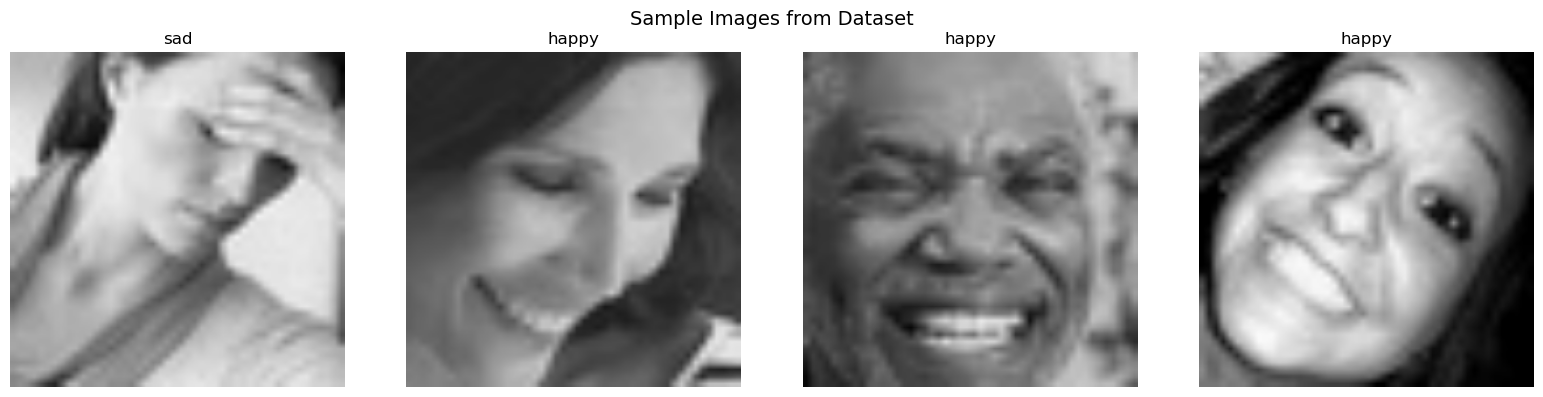

In [43]:
# Visualize some sample images
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
batch = data.as_numpy_iterator().next()
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])
    ax[idx].axis('off')
plt.suptitle('Sample Images from Dataset', fontsize=14)
plt.tight_layout()
plt.show()

# 4. Split Data

Split into Training (70%), Validation (20%), and Test (10%) sets.

In [44]:
# Calculate split sizes
total_batches = len(data)
train_size = int(total_batches * 0.7)
val_size = int(total_batches * 0.2)
test_size = int(total_batches * 0.1) + 1  # +1 to ensure we don't lose data

print(f"Total batches: {total_batches}")
print(f"Train batches: {train_size}")
print(f"Validation batches: {val_size}")
print(f"Test batches: {test_size}")

Total batches: 387
Train batches: 270
Validation batches: 77
Test batches: 39


In [45]:
# Split the data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 5. Data Augmentation

Data augmentation artificially increases dataset size by creating modified versions of images.
This helps the model learn to recognize features regardless of orientation, zoom, or lighting.

In [46]:
# Define augmentation pipeline
data_augmentation = Sequential([
    RandomFlip("horizontal"),           # Flip images left-right
    RandomRotation(0.2),                 # Rotate up to 20%
    RandomZoom(0.2),                     # Zoom in/out up to 20%
    RandomContrast(0.2),                 # Vary contrast up to 20%
], name='data_augmentation')

print("Data augmentation pipeline created!")

Data augmentation pipeline created!


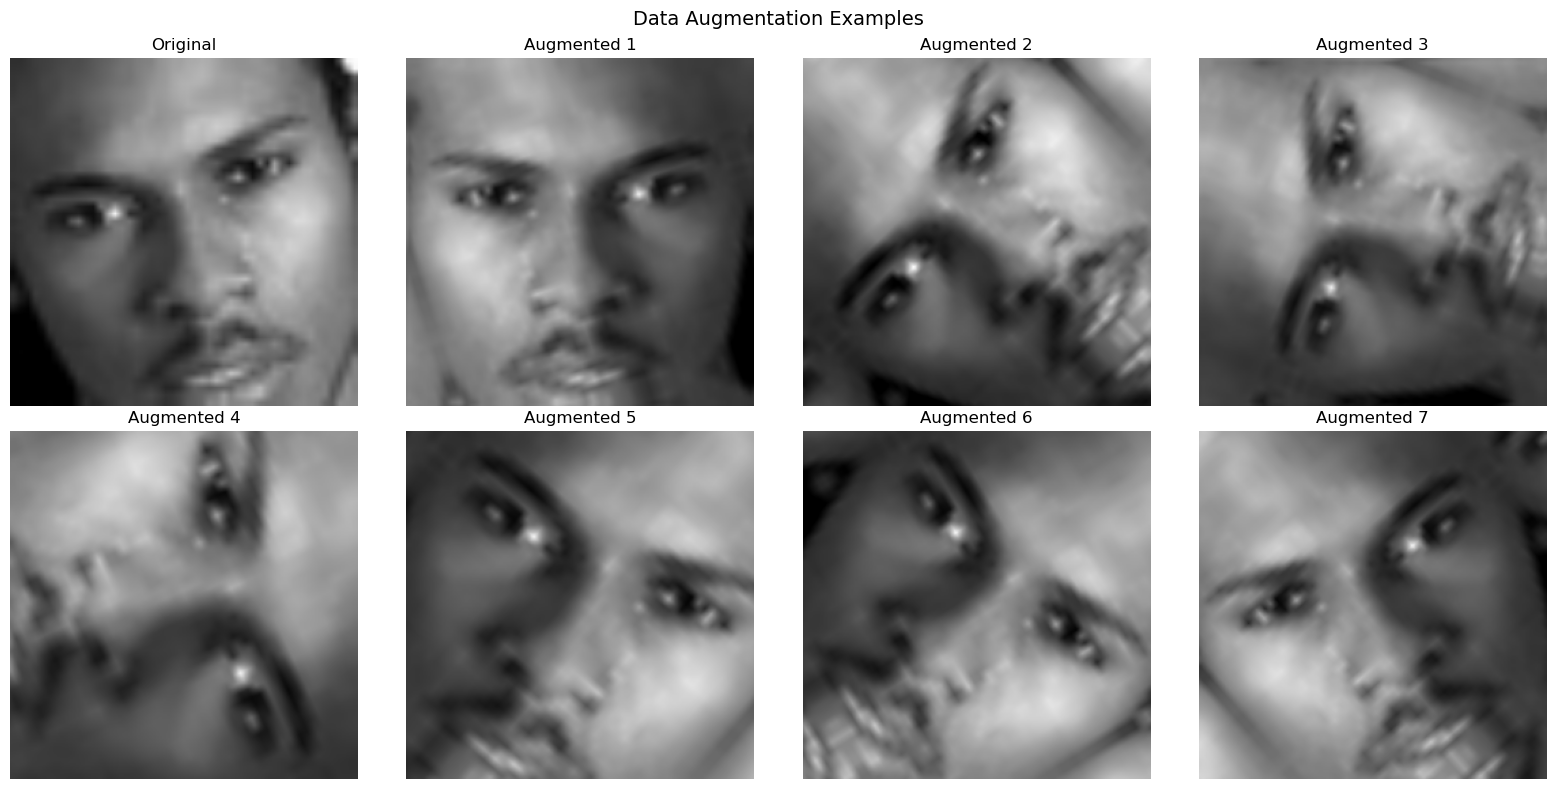

In [47]:
# Visualize augmentation effects
sample_batch = train.take(1).as_numpy_iterator().next()
sample_image = sample_batch[0][0]  # Take first image

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes[0, 0].imshow(sample_image.astype(int))
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i in range(1, 8):
    row = i // 4
    col = i % 4
    augmented = data_augmentation(tf.expand_dims(sample_image, 0))
    axes[row, col].imshow(augmented[0].numpy().astype(int))
    axes[row, col].set_title(f'Augmented {i}')
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=14)
plt.tight_layout()
plt.show()

# 6. Optimize Data Pipeline (NEW - Faster Training)

Using cache, shuffle, and prefetch for better performance.

In [48]:
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training data pipeline
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Optimize validation and test pipelines (no shuffle needed)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

print("Data pipeline optimized!")

Data pipeline optimized!


# 7. Build Model - OPTION A: Custom CNN 

This is original approach but with improvements:
- Scaling inside model
- Data augmentation inside model
- Batch Normalization (stabilizes training)
- Dropout (prevents overfitting)
- GlobalAveragePooling (reduces parameters)
- L2 Regularization

In [ ]:
def build_custom_cnn():
    """Build improved custom CNN model"""
    
    model = Sequential([
        # Input layer with scaling (0-255 -> 0-1)
        Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        # Data augmentation (only active during training)
        data_augmentation,
        
        # Block 1: 32 filters
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 2: 64 filters
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 3: 128 filters
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Classifier head
        GlobalAveragePooling2D(),  # Better than Flatten for small datasets
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ], name='custom_cnn')
    
    return model

print("Custom CNN function defined!")

# 8. Build Model - OPTION B: Transfer Learning

Transfer learning uses a pre-trained model (MobileNetV2) that already knows how to extract features from images.
This is **highly recommended for small datasets** like yours (305 images).

MobileNetV2 was trained on 1.4 million images - we just add our own classifier on top!

In [49]:
def build_transfer_learning_model():
    """Build transfer learning model using MobileNetV2"""
    
    # Load pre-trained MobileNetV2 (without top classification layer)
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,  # Don't include the classification layer
        weights='imagenet'  # Use weights trained on ImageNet
    )
    
    # Freeze the base model (don't train these layers initially)
    base_model.trainable = False
    
    # Build the complete model
    model = Sequential([
        # Input scaling
        Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        # Data augmentation
        data_augmentation,
        
        # Pre-trained base
        base_model,
        
        # Our custom classifier
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ], name='transfer_learning_mobilenetv2')
    
    return model, base_model

print("Transfer learning function defined!")

Transfer learning function defined!


# 9. Choose Model

**Uncomment ONE of the options below:**
- Option A: Custom CNN (if you want to learn CNN architecture)
- Option B: Transfer Learning (RECOMMENDED for best accuracy)

In [50]:
# ============================================
# CHOOSE YOUR MODEL - Uncomment ONE option
# ============================================

# OPTION A: Custom CNN
# model = build_custom_cnn()
# base_model = None

#OPTION B: Transfer Learning (RECOMMENDED)
model, base_model = build_transfer_learning_model()

# ============================================

C:\Users\kshlo\AppData\Local\Temp\ipykernel_33516\456489977.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(
C:\Users\kshlo\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
# Display model summary
model.summary()

Model: "transfer_learning_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 10. Compile Model

In [52]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

print("Model compiled!")

Model compiled!


# 11. Setup Callbacks (NEW - Smart Training)

Callbacks help us:
- Stop training when model stops improving (Early Stopping)
- Reduce learning rate when stuck (ReduceLROnPlateau)
- Save the best model (ModelCheckpoint)
- Track training progress (TensorBoard)

In [53]:
# Create logs directory
logdir = 'logs'
os.makedirs(logdir, exist_ok=True)

# Define callbacks
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,          # Reduce LR by half
        patience=3,          # Wait 3 epochs before reducing
        min_lr=1e-7,         # Minimum learning rate
        verbose=1
    ),
    
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # TensorBoard logging
    TensorBoard(log_dir=logdir)
]

print("Callbacks configured!")

Callbacks configured!


# 12. Train Model - Phase 1

In [54]:
# Training configuration
EPOCHS = 30  # Maximum epochs (early stopping may stop earlier)

print("Starting training...")
print("="*50)

# Train the model
history = model.fit(
    train,
    epochs=EPOCHS,
    validation_data=val,
    callbacks=callbacks
)

print("="*50)
print("Training Phase 1 Complete!")

Starting training...
Epoch 1/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.5889 - loss: 0.7563
Epoch 1: val_accuracy improved from None to 0.67776, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 254s 912ms/step - accuracy: 0.6265 - loss: 0.6975 - val_accuracy: 0.6778 - val_loss: 0.5977 - learning_rate: 0.0010
Epoch 2/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.6914 - loss: 0.5970
Epoch 2: val_accuracy improved from 0.67776 to 0.70373, saving model to best_model.keras

Epoch 2: finished saving model to best_model.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 231s 855ms/step - accuracy: 0.6867 - loss: 0.5972 - val_accuracy: 0.7037 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7072 - loss: 0.5741
Epoch 3: val_accuracy improved from 0.70373 to 0.72078, saving model to best_model.keras

Epoch 3: finished saving model to best_model.keras
270/2

# 13. Fine-Tuning (Only for Transfer Learning)

If you chose Transfer Learning (Option B), this step unfreezes some layers of the base model
for fine-tuning with a very low learning rate.

**Skip this cell if you chose Option A (Custom CNN)**

In [55]:
# ONLY RUN THIS IF YOU CHOSE TRANSFER LEARNING (OPTION B)

if base_model is not None:
    print("Starting fine-tuning...")
    
    # Unfreeze the base model
    base_model.trainable = True
    
    # Freeze all layers except the last 20
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Count trainable layers
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    print(f"Fine-tuning {trainable_count} layers out of {len(base_model.layers)}")
    
    # Recompile with a much lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Very low LR!
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    # Continue training
    history_fine = model.fit(
        train,
        epochs=10,
        validation_data=val,
        callbacks=callbacks
    )
    
    print("Fine-tuning complete!")
else:
    print("Skipping fine-tuning (not using transfer learning)")

Starting fine-tuning...
Fine-tuning 20 layers out of 154
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.6362 - loss: 0.6693
Epoch 1: val_accuracy did not improve from 0.73661
270/270 ━━━━━━━━━━━━━━━━━━━━ 261s 937ms/step - accuracy: 0.6715 - loss: 0.6237 - val_accuracy: 0.6907 - val_loss: 0.5958 - learning_rate: 1.0000e-05
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.7169 - loss: 0.5668
Epoch 2: val_accuracy did not improve from 0.73661
270/270 ━━━━━━━━━━━━━━━━━━━━ 256s 951ms/step - accuracy: 0.7175 - loss: 0.5607 - val_accuracy: 0.7163 - val_loss: 0.5560 - learning_rate: 1.0000e-05
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.7260 - loss: 0.5462
Epoch 3: val_accuracy improved from 0.73661 to 0.73742, saving model to best_model.keras

Epoch 3: finished saving model to best_model.keras
270/270 ━━━━━━━━━━━━━━━━━━━━ 254s 941ms/step - accuracy: 0.7363 - loss: 0.5338 - val_accuracy: 0.7374 - val_loss: 0.5278 - learning_rate: 

# 14. Plot Training Performance

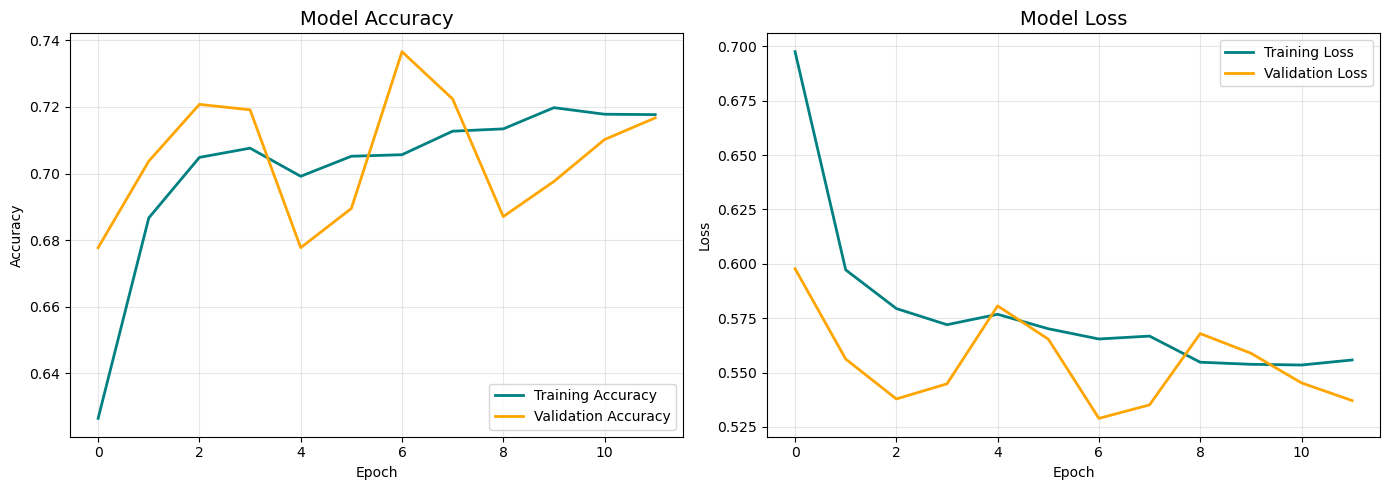


Final Training Accuracy: 0.7177
Final Validation Accuracy: 0.7167
Gap (Train - Val): 0.0010
✅ Model is generalizing well!


In [58]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='teal', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot Loss
axes[1].plot(history.history['loss'], label='Training Loss', color='teal', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
gap = final_train_acc - final_val_acc

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Gap (Train - Val): {gap:.4f}")

if gap > 0.1:
    print("⚠️  Warning: Model may be overfitting (gap > 10%)")
else:
    print("✅ Model is generalizing well!")

# 15. Evaluate on Test Set

In [59]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test)

print(f"\n" + "="*50)
print(f"TEST RESULTS")
print(f"="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"="*50)

Evaluating on test set...
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - accuracy: 0.8542 - loss: 0.3320

TEST RESULTS
Test Loss: 0.3320
Test Accuracy: 0.8542 (85.42%)


# 16. Detailed Evaluation - Confusion Matrix & Classification Report

In [60]:
# Get predictions on test set
y_true = []
y_pred = []
y_pred_proba = []

for batch in test:
    X, y = batch
    predictions = model.predict(X, verbose=0)
    y_true.extend(y.numpy())
    y_pred_proba.extend(predictions.flatten())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

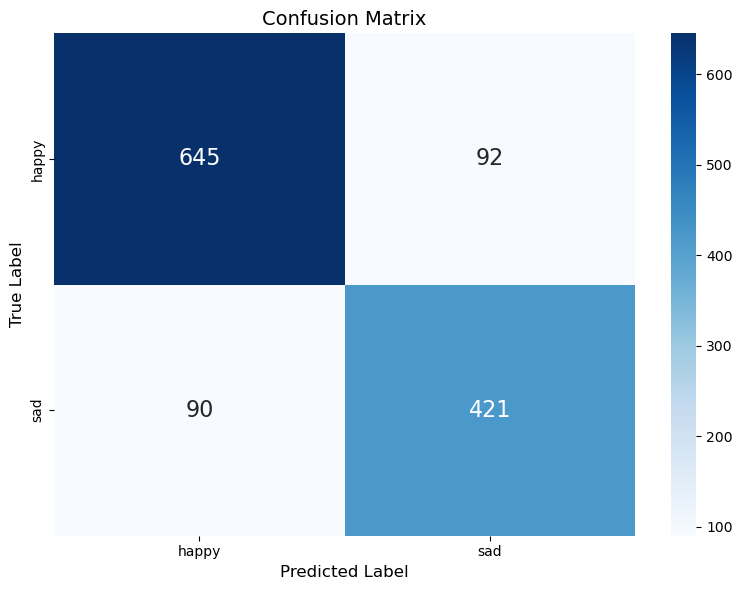


Classification Report:
              precision    recall  f1-score   support

       happy       0.88      0.88      0.88       737
         sad       0.82      0.82      0.82       511

    accuracy                           0.85      1248
   macro avg       0.85      0.85      0.85      1248
weighted avg       0.85      0.85      0.85      1248



In [61]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 16}
)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# 17. Visualize Predictions

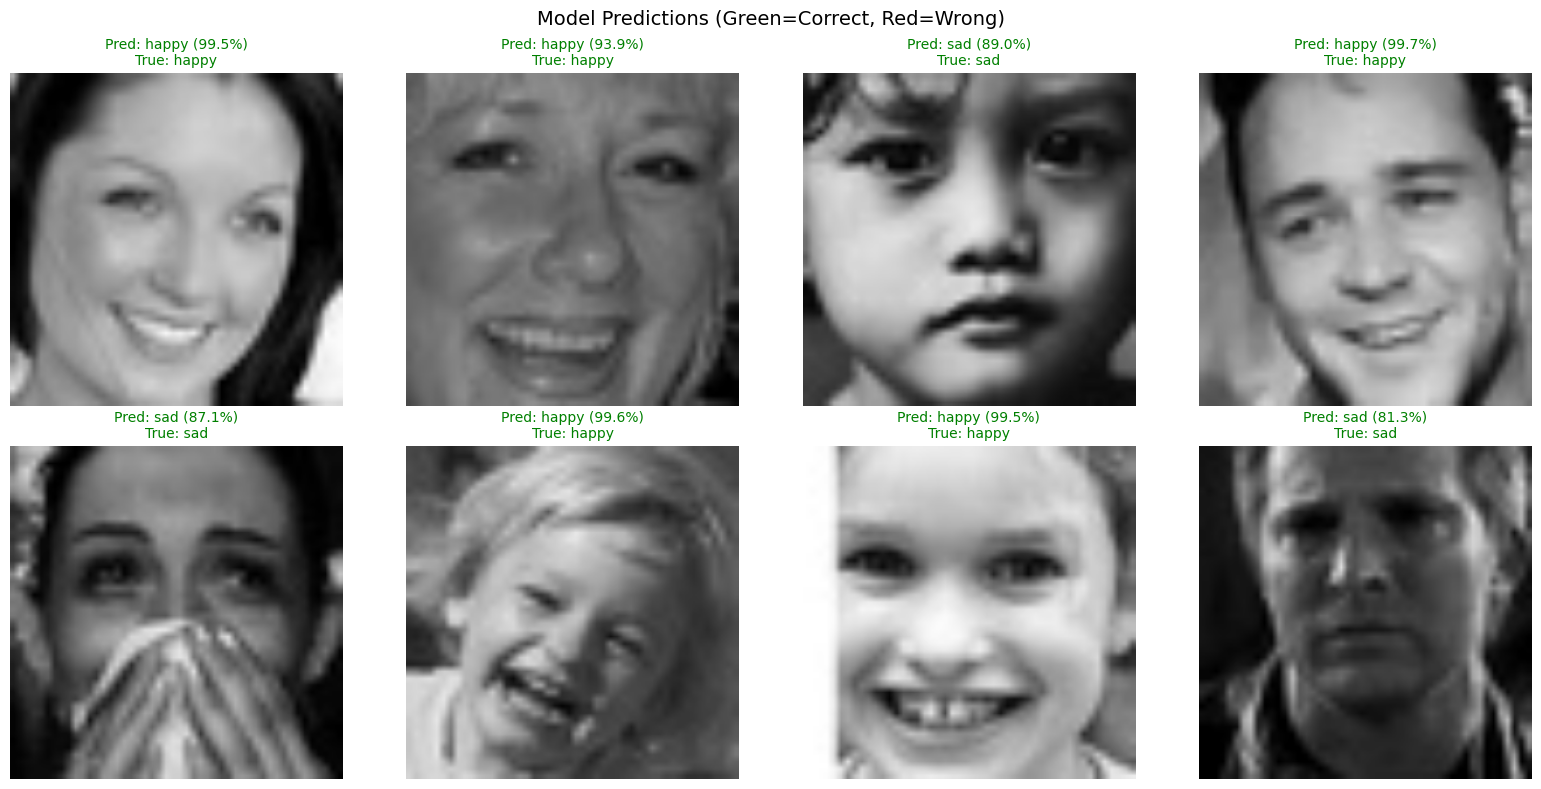

In [62]:
# Get a batch of test images for visualization
test_batch = test.take(1).as_numpy_iterator().next()
test_images, test_labels = test_batch

# Make predictions
predictions = model.predict(test_images, verbose=0)

# Plot predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, ax in enumerate(axes.flat):
    if i < len(test_images):
        ax.imshow(test_images[i].astype(int))
        
        pred_class = class_names[1] if predictions[i] > 0.5 else class_names[0]
        true_class = class_names[test_labels[i]]
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]
        
        color = 'green' if pred_class == true_class else 'red'
        ax.set_title(f'Pred: {pred_class} ({confidence:.1%})\nTrue: {true_class}', 
                    color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('Model Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()

# 18. Save Model

In [ ]:
# Save the final model
model.save('happy_sad_classifier_final.keras')
print("Model saved as 'happy_sad_classifier_final.keras'")

# Note: 'best_model.keras' was saved by ModelCheckpoint callback during training

# 19. Load and Test Saved Model

In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model('happy_sad_classifier_final.keras')
print("Model loaded successfully!")

# 20. Test on a Single Image

In [63]:
def predict_single_image(image_path, model):
    """
    Predict class for a single image
    
    Args:
        image_path: Path to the image file
        model: Trained model
    
    Returns:
        Predicted class and confidence
    """
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Add batch dimension
    img_array = np.expand_dims(img_resized, axis=0)
    
    # Predict
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Determine class
    predicted_class = class_names[1] if prediction > 0.5 else class_names[0]
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(img_resized)
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}', fontsize=14)
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

print("predict_single_image() function defined!")
print("\nUsage: predict_single_image('path/to/your/image.jpg', model)")

predict_single_image() function defined!

Usage: predict_single_image('path/to/your/image.jpg', model)


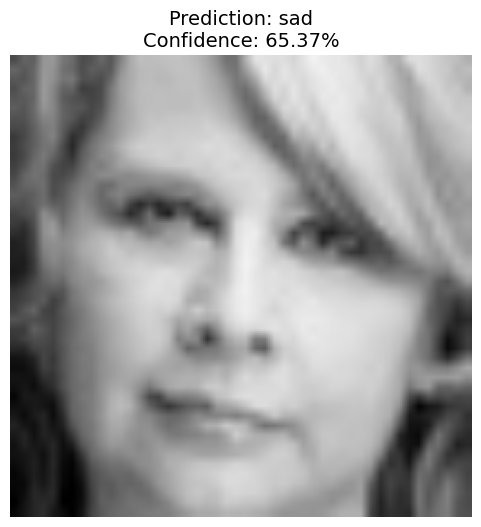

('sad', np.float32(0.6537361))

In [74]:
# Example: Test on a single image (uncomment and modify path)
predict_single_image(
    r"C:\Users\kshlo\ImageClassification\test images\PublicTest_94796042.jpg",
    model
)


# Summary

## What We Improved:

| Feature | Original | Improved |
|---------|----------|----------|
| Data Augmentation | ❌ None | ✅ Flip, Rotate, Zoom, Contrast |
| Regularization | ❌ None | ✅ Dropout + L2 |
| Batch Normalization | ❌ No | ✅ Yes |
| Early Stopping | ❌ No | ✅ Yes (patience=5) |
| Learning Rate Schedule | ❌ No | ✅ ReduceLROnPlateau |
| Model Checkpointing | ❌ No | ✅ Save best model |
| Architecture | Basic CNN | Transfer Learning (MobileNetV2) |
| Evaluation | Basic accuracy | Confusion Matrix + Classification Report |

## Tips for Even Better Results:

1. **Get More Data**: 305 images is quite small. Try to collect at least 1000+ images per class.

2. **Balance Your Dataset**: Make sure you have equal numbers of happy and sad images.

3. **Try Different Base Models**: Instead of MobileNetV2, try:
   - `tf.keras.applications.EfficientNetB0` (more accurate, slower)
   - `tf.keras.applications.ResNet50` (very accurate, slower)

4. **Experiment with Hyperparameters**:
   - Learning rate: Try 0.0001, 0.001, 0.01
   - Dropout rate: Try 0.3, 0.5, 0.7
   - Batch size: Try 16, 32, 64